In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.constants import G
from astropy import units as u
import symlib
import os
import seaborn as sns

suite_names = ["SymphonyLMC", "SymphonyMilkyWay", "SymphonyGroup", "SymphonyLCluster", "SymphonyCluster"]
sim_colors = {
        "SymphonyLMC": sns.color_palette("colorblind")[4],
        "SymphonyMilkyWay": sns.color_palette("colorblind")[0],
        "SymphonyGroup": sns.color_palette("colorblind")[2],
        "SymphonyLCluster": sns.color_palette("colorblind")[1],
        "SymphonyCluster": sns.color_palette("colorblind")[3],
    }
sim_names = {
        "SymphonyLMC": "LMC",
        "SymphonyMilkyWay": "Milky~Way",
        "SymphonyGroup": "Group",
        "SymphonyLCluster": "L-Cluster",
        "SymphonyCluster": "Cluster",
    }
mean_cvir = {
    "SymphonyLMC": 12.2,
    "SymphonyMilkyWay": 10.8,
    "SymphonyGroup": 9.0,
    "SymphonyLCluster": 5.0,
    "SymphonyCluster": 5.6,
}


In [ ]:

def density_velocity_mass(base_dir, suite_name, output_dir, snap, n_bins=40, r_min=1e-3, r_max=1.5):
    """
    Measure and save the density, velocity dispersion, velocity anisotropy and enclosed mass profile of each host halo in a suite at a given snapshot.

    Density is normalized to the backgroung matter density rho_m = Omega_m * rho_crit at z=0.
    Velocity dispersion is normalized to virial velocity at given snapshot.
    Enclosed mass is normalized to virial mass at given snapshot.

    Parameters
    ----------
    base_dir : str
        Root directory of the simulation suite containing all halo data.
    
    suite_name : str
        Name of the simulation suite (e.g., 'SymphonyLMC').

    snap : int
        Snapshot number to read particle data from.

    n_bins : int
        Number of logarithmic radial bins used for density profile computation.

    r_min : float
        Minimum radius (in units of R_vir) for the radial binning range.

    r_max : float
        Maximum radius (in units of R_vir) for the radial binning range.

    """
    def density_profile():

        # Read basic simulation parameters
        n_halos = symlib.n_hosts(suite_name)
        params = symlib.simulation_parameters(suite_name)
        h = params['h100']
        mp = params['mp'] / h  # Particle mass [Msun]
        eps = params['eps'] / h  # Softening length [kpc]
        H0 = params["H0"]  # Hubble constant [km/s/Mpc]
        Om0 = params["Om0"]  # Matter density parameter at z=0

        # Compute background matter density rho_m = Omega_m * rho_crit
        H0_si = params["H0"] * u.km / u.s / u.Mpc
        G_si = G.to(u.Mpc**3 / u.Msun / u.s**2)
        rho_crit = (3 * H0_si**2 / (8 * np.pi * G_si)).to(u.Msun / u.kpc**3).value
        rho_m = Om0 * rho_crit
        print(f'Om0={Om0}')

        cvir = []
        mvir = []

        for halo_idx in range(n_halos):
            # Get path to the current halo
            sim_dir = symlib.get_host_directory(base_dir, suite_name, halo_idx)
            
            try:
                # Read Rockstar halo catalog
                r, hist = symlib.read_rockstar(sim_dir)
                host = r[0, snap]
            except:
                print(f"[Warning] Rockstar file not found for Halo {halo_idx}")
                continue

            center = host['x']   # Halo center position
            r_vir = host['rvir']     # Virial radius [kpc]


            cvir_val = host['cvir']
            cvir.append(cvir_val)
            mvir_val = host['m']
            mvir.append(mvir_val)

            # Read particle snapshot
            try:
                part = symlib.Particles(sim_dir)
                p = part.read(snap)
            except:
                print(f"[Warning] Particle snapshot not found for Halo {halo_idx}")
                continue

            # Compute radial distances from halo center
            x = p[0]['x']
            dx = x - center
            radi = np.linalg.norm(dx, axis=1)
            radi_scaled = radi / r_vir

            # Create logarithmic radial bins
            bins = np.logspace(np.log10(r_min), np.log10(r_max), n_bins + 1)
            bin_centers = 0.5 * (bins[1:] + bins[:-1])

            # Compute mass in each spherical shell
            counts, _ = np.histogram(radi_scaled, bins=bins)
            shell_volumes = (4/3) * np.pi * ((bins[1:] * r_vir)**3 - (bins[:-1] * r_vir)**3)
            mass_per_bin = counts * mp
            rho = mass_per_bin / shell_volumes  # Density [Msun/kpc^3]
            rho_scaled = rho / rho_m            # Scaled by background density

            # Save density profile to CSV
            df = pd.DataFrame({
                "halo_idx": halo_idx,
                "r_scaled": bin_centers,
                "rho_scaled": rho_scaled
            })

            out_path = f"{output_dir}/{suite_name}/density_profiles"
            os.makedirs(out_path, exist_ok=True)
            df.to_csv(f"{out_path}/halo_{halo_idx:03d}_profile.csv", index=False)

            print(f"[Saved] {suite_name} Halo {halo_idx:03d} density profile saved.")

        # Return mean concentration and mass across halos
        mean_cvir = np.mean(cvir)
        mean_mvir = np.mean(mvir)
        print(f'mean cvir of {suite_name} is: {mean_cvir}, mean mvir is: {mean_mvir}')

    def velocity_profile():

        # Read halo count and cosmological/simulation parameters
        n_halos = symlib.n_hosts(suite_name)
        print(n_halos)
        params = symlib.simulation_parameters(suite_name)
        h = params['h100']
        eps = params['eps'] * h  # kpc
        H0 = params["H0"]  # km/s/Mpc

        for halo_idx in range(n_halos):
            sim_dir = symlib.get_host_directory(base_dir, suite_name, halo_idx)

            # Load host halo data
            try:
                r, hist = symlib.read_rockstar(sim_dir)
                host = r[0, snap]
            except FileNotFoundError:
                print(f"[Warning] Rockstar file not found for Halo {halo_idx}")
                continue

            # Compute virial velocity
            center = host['x']         # Halo center [kpc]
            v_host = host['v']         # Halo bulk velocity [km/s]
            r_vir = host['rvir']           # Virial radius [kpc]
            m_vir = host['m']              # Virial mass [Msun]
            m = m_vir * u.Msun
            r = r_vir * u.kpc
            G_kpc = G.to(u.kpc * (u.km/u.s)**2 / u.Msun)
            v_vir = np.sqrt(G_kpc * m / r).to(u.km / u.s).value  # Virial velocity [km/s]

            # Load particle data
            try:
                part = symlib.Particles(sim_dir)
                p = part.read(snap)
            except FileNotFoundError:
                print(f"[Warning] Particle snapshot not found for Halo {halo_idx}")
                continue

            # Positions and velocities in host frame
            x = p[0]['x']  # positions [kpc]
            v = p[0]['v']  # velocities [km/s]
            dx = x - center
            dv = v - v_host
            radi = np.linalg.norm(dx, axis=1)
            radi_scaled = radi / r_vir

            # Decompose velocities: radial vs tangential
            r_hat = dx / radi[:, None]
            v_rad = np.sum(dv * r_hat, axis=1)
            v_tan = dv - v_rad[:, None] * r_hat

            # Set up logarithmic radial bins
            bins = np.logspace(np.log10(r_min), np.log10(r_max), n_bins + 1)
            bin_centers = 0.5 * (bins[1:] + bins[:-1])

            # Containers for profiles
            sigma_rad_scaled = []
            sigma_tan_scaled = []
            sigma_total_scaled = []
            beta_profile = []

            # Compute statistics in each bin
            for i in range(n_bins):
                in_bin = (radi_scaled >= bins[i]) & (radi_scaled < bins[i + 1])

                # Radial velocity dispersion
                sigma_rad = np.std(v_rad[in_bin])
                sigma_rad_scaled.append(sigma_rad / v_vir)

                # Total velocity dispersion (quadrature of components)
                sigma_x = np.std(dv[in_bin][:, 0])
                sigma_y = np.std(dv[in_bin][:, 1])
                sigma_z = np.std(dv[in_bin][:, 2])
                sigma_total = np.sqrt(sigma_x**2 + sigma_y**2 + sigma_z**2)
                sigma_total_scaled.append(sigma_total / v_vir)

                if sigma_total < sigma_rad:  
                    sigma_total = sigma_rad

                # Tangential dispersion (from subtraction)
                sigma_tan = np.sqrt(max(0, sigma_total**2 - sigma_rad**2))
                sigma_tan_scaled.append(sigma_tan / v_vir)

                # Velocity anisotropy beta = 1 - (sigma_tan^2) / (2 * sigma_rad^2)
                if sigma_rad == 0:
                    beta = np.nan
                else:
                    beta = 1 - sigma_tan**2 / (2 * sigma_rad**2)
                beta_profile.append(beta)

            # Save velocity profile for this halo
            df = pd.DataFrame({
                "halo_idx": halo_idx,
                "r_scaled": bin_centers,
                "sigma_rad_scaled": sigma_rad_scaled,
                "sigma_tan_scaled": sigma_tan_scaled,
                "sigma_total_scaled": sigma_total_scaled,
                "beta": beta_profile
            })

            out_path = f"{output_dir}/{suite_name}/velocity_profiles"
            os.makedirs(out_path, exist_ok=True)
            df.to_csv(f"{out_path}/halo_{halo_idx:03d}_profile.csv", index=False)

            print(f"[Saved] {suite_name} Halo {halo_idx:03d} velocity profile saved.")

    def mass_profile():

        # Simulation parameters
        n_halos = symlib.n_hosts(suite_name)
        params = symlib.simulation_parameters(suite_name)
        h = params['h100']
        mp = params['mp'] / h
        eps = params['eps'] / h

        # Prepare storage for all profiles
        all_r_scaled = []
        all_m_scaled = []

        for halo_idx in range(n_halos):
            sim_dir = symlib.get_host_directory(base_dir, suite_name, halo_idx)

            try:
                r, hist = symlib.read_rockstar(sim_dir)
                host = r[0, snap]
            except FileNotFoundError:
                print(f"[Warning] Rockstar file not found for Halo {halo_idx}")
                continue

            center = host['x']
            m_vir = host['m']
            r_vir = host['rvir']

            try:
                part = symlib.Particles(sim_dir)
                p = part.read(snap)
            except FileNotFoundError:
                print(f"[Warning] Particle snapshot not found for Halo {halo_idx}")
                continue

            x = p[0]['x']
            dx = x - center
            radi = np.linalg.norm(dx, axis=1)
            radi_scaled = radi / r_vir

            bins = np.logspace(np.log10(r_min), np.log10(r_max), n_bins + 1)
            bin_centers = 0.5 * (bins[1:] + bins[:-1])

            counts, _ = np.histogram(radi_scaled, bins=bins)
            mass_per_bin = counts * mp
            enclosed_mass = np.cumsum(mass_per_bin)
            m_scaled = enclosed_mass / m_vir

            # Save profile for later global plot
            all_r_scaled.append(bin_centers)
            all_m_scaled.append(m_scaled)

            # Save to CSV
            df = pd.DataFrame({
                "halo_idx": halo_idx,
                "r_scaled": bin_centers,
                "m_scaled": m_scaled
            })
            out_path = f"{output_dir}/{suite_name}/mass_profiles"
            os.makedirs(out_path, exist_ok=True)
            df.to_csv(f"{out_path}/halo_{halo_idx:03d}_profile.csv", index=False)

            print(f"[Saved] {suite_name} Halo {halo_idx:03d} mass profile saved.")

    # main loop
    density_profile()
    velocity_profile()
    mass_profile()

# example save halos at z=1
suite_names = ["SymphonyLMC", "SymphonyMilkyWay", "SymphonyGroup", "SymphonyLCluster", "SymphonyCluster"]

for suite in suite_names:
    if suite in ["SymphonyLMC", "SymphonyMilkyWay", "SymphonyGroup"]:
        snap = 181
    else:
        snap = 146

    if suite in ["SymphonyLMC", "SymphonyMilkyWay", "SymphonyLCluster"]:
        base_dir = '/Volumes/Atlas/Symphony'
    else:
        base_dir = '/Volumes/Carol/Symphony'
    output_dir='/Users/fengbocheng/Projects/Symphony-PPSD/output/z_1'
    density_velocity_mass(base_dir, suite, output_dir, snap)

In [ ]:
def particle_counts_distribution(base_dir, suite_name, snap, n_bins=40, r_min=0.001, r_max=1.5):
    """
    Compute the average radial distribution of particle counts across all host halos
    in a simulation suite, normalized by the host halo's virial radius.
    """

    # Get total number of host halos
    n_halos = symlib.n_hosts(suite_name)
    all_counts = []

    # Define radial bin edges and centers (uniform across all halos)
    bins = np.logspace(np.log10(r_min), np.log10(r_max), n_bins + 1)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    for halo_idx in range(n_halos):
        sim_dir = symlib.get_host_directory(base_dir, suite_name, halo_idx)

        # Load halo center and R_vir from Rockstar catalog
        try:
            r, hist = symlib.read_rockstar(sim_dir)
            host = r[0, snap]
        except FileNotFoundError:
            print(f"[Warning] Rockstar file not found for Halo {halo_idx}, skipped.")
            continue

        center = host['x']      # Halo center [kpc]
        r_vir = host['rvir']         # Virial radius [kpc]

        # Load particle data
        part = symlib.Particles(sim_dir)
        try:
            p = part.read(snap)
        except FileNotFoundError:
            print(f"[Warning] Particle snapshot not found for Halo {halo_idx}, skipped.")
            continue

        x = p[0]['x']
        dx = x - center
        radi = np.linalg.norm(dx, axis=1)        # Distance from halo center [kpc]
        radi_scaled = radi / r_vir               # Normalize radius by R_vir

        # Bin particles by scaled radius
        counts, _ = np.histogram(radi_scaled, bins=bins)
        all_counts.append(counts)

    if len(all_counts) == 0:
        raise RuntimeError("No halo data available for particle count statistics.")

    all_counts = np.array(all_counts)            # (n_halos, n_bins)
    mean_counts = np.mean(all_counts, axis=0)    # Mean across halos
    stderr_counts = np.std(all_counts, axis=0) / np.sqrt(all_counts.shape[0])  # Standard error

    plt.figure(figsize=(7, 5),dpi=500)
    plt.plot(bin_centers, mean_counts, label='Mean Particle Counts', color='pink')
    plt.fill_between(bin_centers, mean_counts - stderr_counts, mean_counts + stderr_counts,
                    color='blue', alpha=0.3, label='Standard Error')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r"$r / r_{\mathrm{vir}}$")
    plt.ylabel("Average Particle Counts per Bin")
    plt.title(f"Average Particle Counts Profile across {len(all_counts)} Halos")
    plt.legend()
    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    return bin_centers, mean_counts, stderr_counts


In [ ]:
import os
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# ln rho(r) = ln rho_-2 - (2/alpha) * [ (r / r_-2)^alpha - 1 ]
def einasto_log_model(r, log_rho2, alpha, r_s):
    x = r / r_s
    return log_rho2 - (2.0 / alpha) * (np.power(x, alpha) - 1.0)
def plot_density_profiles_mean_einasto(mask_range=(1e-3, 1.5)):
    plt.figure(figsize=(6, 5), dpi=500)
    plt.rcParams["text.usetex"] = True
    plt.plot([], [], ls="--", color="black", lw=0.9, label=r"$\mathrm{Einasto\ fit}$")

    einasto_params = {}  # <---- store parameters here

    for suite in suite_names:
        # load suite profiles
        prof_dir = os.path.join(base_dir, "output", suite, "density_profiles")
        files = sorted(glob(os.path.join(prof_dir, "halo_*_profile.csv")))
        if not files:
            continue
        profs = [pd.read_csv(f) for f in files]

        r_all = profs[0]["r_scaled"].to_numpy()
        mask = (r_all >= mask_range[0]) & (r_all <= mask_range[1]) if mask_range else slice(None)
        r = r_all[mask]

        rho_stack = np.array([
            (df["rho_scaled"].to_numpy()[mask] if mask_range else df["rho_scaled"].to_numpy())
            for df in profs
        ])
        rho_mean = np.nanmean(rho_stack, axis=0)
        rho_std  = np.nanstd(rho_stack, axis=0)

        valid = np.isfinite(r) & np.isfinite(rho_mean) & (r > 0) & (rho_mean > 0)
        r_fit  = r[valid]
        yln_fit = np.log(rho_mean[valid])

        p0     = [np.log(np.median(np.exp(yln_fit))), 0.18, 0.1]
        bounds = ([-50.0, 0.05, 1e-3], [50.0, 0.6, 0.5])
        popt, _ = curve_fit(einasto_log_model, r_fit, yln_fit,
                            p0=p0, bounds=bounds, maxfev=50000)
        log_rho2, alpha, r_minus2 = popt

        # store in dictionary
        einasto_params[suite] = (float(log_rho2), float(alpha), float(r_minus2))

        # plot mean ± std and overlay
        color = sim_colors[suite]
        label = rf"$\mathrm{{{sim_names[suite]}}}\;(\alpha={alpha:.3f})$"
        plt.loglog(r, rho_mean * r**2, lw=1.0, color=color, label=label)
        plt.fill_between(r, (rho_mean - rho_std) * r**2, (rho_mean + rho_std) * r**2,
                         color=color, alpha=0.25, lw=0)

        rho_fit = np.exp(einasto_log_model(r, log_rho2, alpha, r_minus2))
        plt.loglog(r, rho_fit * r**2, ls="--", lw=0.9, color=color)

    # cosmetics
    plt.axvline(3.38e-3, ls=":" ,lw=0.9, color='black')
    plt.xlabel(r"$r / R_{\mathrm{vir}}$", fontsize=18)
    plt.ylabel(r"$(\rho / \rho_m)\,(r/R_{\mathrm{vir}})^2$", fontsize=18)
    plt.xscale("log"); plt.yscale("log")
    plt.xlim(1e-3, 1.5); plt.ylim(1, 4e2)
    plt.legend(loc="best", fontsize=12, frameon=False)
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, "density_profiles.pdf"))
    plt.show()
    plt.close()

    # print the dictionary so you can copy into velocity code
    print("\nEinasto parameters by suite (log_rho_minus2, alpha, r_minus2/Rvir):")
    for k, v in einasto_params.items():
        print(f"'{k}': {v},")
        
plot_density_profiles_mean_einasto(mask_range=(1e-3, 1.5))


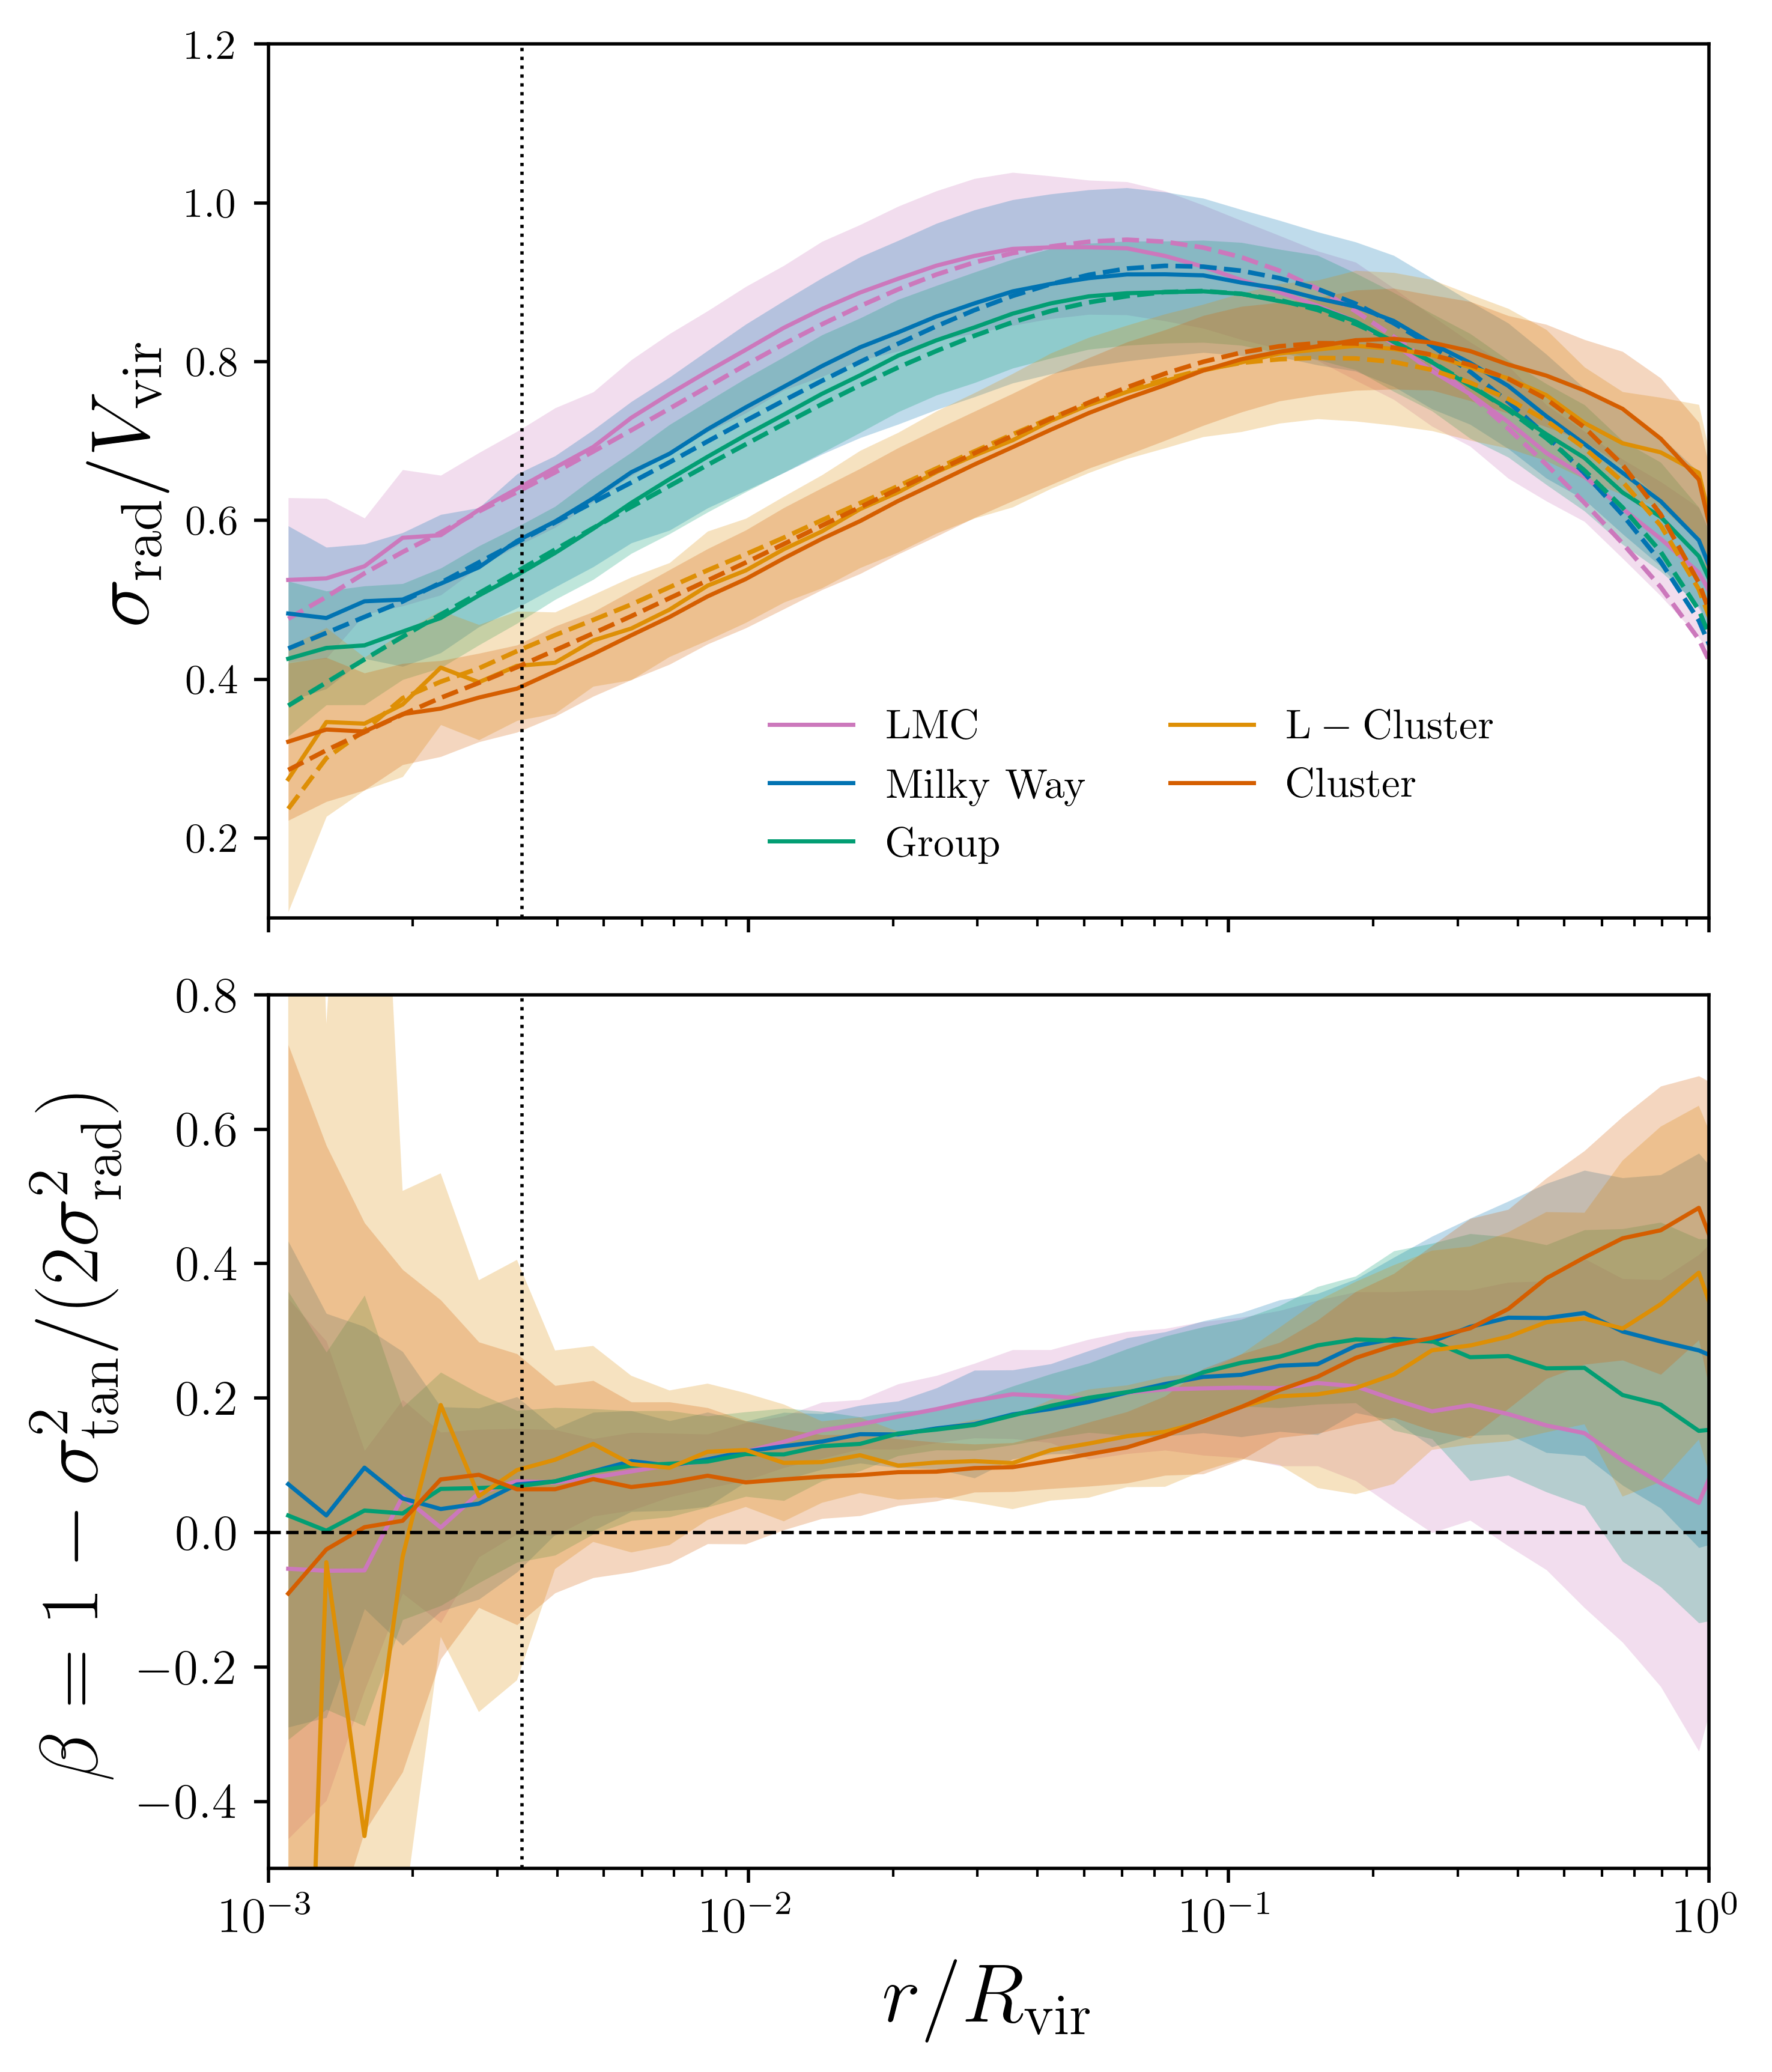

     SymphonyLMC: alpha = 0.300, c = 8.92
SymphonyMilkyWay: alpha = 0.262, c = 8.12
   SymphonyGroup: alpha = 0.173, c = 8.62
SymphonyLCluster: alpha = 0.181, c = 5.00
 SymphonyCluster: alpha = 0.174, c = 5.00


In [17]:
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.integrate import cumulative_trapezoid as cumtrapz, trapezoid

# ------------------------------------------------------------
# All in virial units (Rvir = Vvir = G = 1)
# ------------------------------------------------------------
def einasto_rho(r, alpha, r2, rho2):
    x = (r / r2)**alpha
    return rho2 * np.exp(-(2.0/alpha)*(x - 1.0))

def einasto_mass(r, alpha, r2, rho2):
    """M(<r) = 4π ∫_0^r ρ(s) s^2 ds on the provided r-grid (monotonic)."""
    s = r
    rho = einasto_rho(s, alpha, r2, rho2)
    integrand = 4*np.pi * rho * s**2
    M = np.concatenate(([0.0], cumtrapz(integrand, s)))
    return M

def rho2_for_Mvir_equals_one(r_grid, alpha, r2):
    """
    Choose rho_-2 so that M(<1)=1 in virial units.
    We compute the mass at r=1 with rho2=1, then scale.
    """
    rho2_trial = 1.0
    M_trial = einasto_mass(r_grid, alpha, r2, rho2_trial)
    M1 = np.interp(1.0, r_grid, M_trial)
    if M1 <= 0 or not np.isfinite(M1):
        return np.nan
    return 1.0 / M1 

def jeans_sigma_r_on_grid(r_grid, beta_grid, alpha, c):
    """
    Compute sigma_r(r)/Vvir on r_grid given beta(r) (same grid),
    Einasto params (alpha, c=1/r2). Enforce M(1)=1 normalization.
    """
    r = r_grid
    r2 = 1.0 / c
    rho2 = rho2_for_Mvir_equals_one(r, alpha, r2)
    if not np.isfinite(rho2) or rho2 <= 0:
        return np.full_like(r, np.nan)

    rho = einasto_rho(r, alpha, r2, rho2)
    M   = einasto_mass(r, alpha, r2, rho2)  # dimensionless; G=1

    integrand = np.where(r > 0, beta_grid / r, 0.0)
    I_beta = np.concatenate(([0.0], cumtrapz(integrand, r))) 
    base = np.where(r > 0, rho * M / (r**2), 0.0)
    B = base * np.exp(2.0 * I_beta)
    P = np.concatenate(([0.0], cumtrapz(B, r)))
    J = (P[-1] - P) * np.exp(-2.0 * I_beta)

    sigma2 = np.where(rho > 0, J / rho, np.nan)
    sigma  = np.sqrt(np.maximum(sigma2, 0.0))
    return sigma

from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import numpy as np

def fit_einasto_sigma_r(
    r, beta_mean, sig_mean,
    alpha_bounds=(0.10, 0.30), c_bounds=(5.0, 15.0),
    r_fit_min=1e-3, r_fit_max=1.0
):
    """Fit (alpha, c) using curve_fit with a correctly-shaped model f(r_eval, alpha, c)."""

    # Select the fit window and clean NaNs
    mask = np.isfinite(r) & np.isfinite(beta_mean) & np.isfinite(sig_mean) \
           & (r >= r_fit_min) & (r <= r_fit_max)
    r_fit   = np.asarray(r[mask])
    beta_fit= np.asarray(beta_mean[mask])
    sig_fit = np.asarray(sig_mean[mask])

    # curve_fit requires x sorted and model returns predictions on x as-is
    sort_idx = np.argsort(r_fit)
    r_fit    = r_fit[sort_idx]
    beta_fit = beta_fit[sort_idx]
    sig_fit  = sig_fit[sort_idx]

    # Build a model with the required signature: f(r_eval, alpha, c)
    def model_for_curvefit(r_eval, alpha, c):
        # Ensure r_eval is a numpy array
        r_eval = np.asarray(r_eval)

        # Build a union grid covering both the reference (for beta) and r_eval
        r_union = np.unique(np.concatenate([r_fit, r_eval]))
        # Interpolate beta onto union
        beta_union = interp1d(r_fit, beta_fit, kind="linear", bounds_error=False,
                              fill_value=(beta_fit[0], beta_fit[-1]))(r_union)
        # Solve Jeans on the union grid once
        sigma_union = jeans_sigma_r_on_grid(r_union, beta_union, alpha, c)

        # Interpolate solution back to r_eval (preserve the original order of r_eval)
        return np.interp(r_eval, r_union, sigma_union)

    # Initial guess and bounds
    p0 = (0.20, 10.0)
    bounds = ([alpha_bounds[0], c_bounds[0]],
              [alpha_bounds[1], c_bounds[1]])

    # Run fit (bounded -> trust region reflective under the hood)
    popt, pcov = curve_fit(
        model_for_curvefit, r_fit, sig_fit,
        p0=p0, bounds=bounds, maxfev=3000
    )
    alpha_hat, c_hat = popt

    # Build the full-grid prediction for plotting/output
    beta_full = interp1d(r_fit, beta_fit, kind="linear", bounds_error=False,
                         fill_value=(beta_fit[0], beta_fit[-1]))(r)
    sig_model = jeans_sigma_r_on_grid(r, beta_full, alpha_hat, c_hat)

    return alpha_hat, c_hat, sig_model

def plot_sigma_r_and_beta_einasto():
    fig, (ax_sig, ax_beta) = plt.subplots(2, 1, figsize=(6, 7), dpi=500, sharex=True)
    plt.rcParams['text.usetex'] = True

    fit_report = []  

    for suite in suite_names:
        vdir = os.path.join(base_dir, "output", suite, "velocity_profiles")
        files = sorted(glob(os.path.join(vdir, "halo_*_profile.csv")))
        if not files:
            continue

        profs   = [pd.read_csv(f) for f in files]
        r       = profs[0]["r_scaled"].to_numpy()
        sig_r   = np.vstack([p["sigma_rad_scaled"].to_numpy() for p in profs])
        beta    = np.vstack([p["beta"].to_numpy()              for p in profs])

        sig_mean, sig_std   = np.nanmean(sig_r, axis=0), np.nanstd(sig_r, axis=0)
        beta_mean, beta_std = np.nanmean(beta, axis=0), np.nanstd(beta, axis=0)

        ax_sig.plot(r, sig_mean, lw=1, color=sim_colors[suite], label=rf"$\mathrm{{{sim_names[suite]}}}$")
        ax_sig.fill_between(r, sig_mean - sig_std, sig_mean + sig_std,
                            color=sim_colors[suite], alpha=0.25, lw=0)

        alpha_hat, c_hat, sig_model = fit_einasto_sigma_r(
            r=r, beta_mean=beta_mean, sig_mean=sig_mean,
            alpha_bounds=(0.1, 0.3), c_bounds=(5.0, 15.0),
            r_fit_min=1e-3, r_fit_max=1
        )
        fit_report.append((suite, alpha_hat, c_hat))

        ax_sig.plot(r, sig_model, ls="--", lw=1.1, color=sim_colors[suite])

        ax_beta.semilogx(r, beta_mean, lw=1, color=sim_colors[suite], label=rf"$\mathrm{{{sim_names[suite]}}}$")
        ax_beta.fill_between(r, beta_mean - beta_std, beta_mean + beta_std,
                             color=sim_colors[suite], alpha=0.25, lw=0)

    ax_sig.set_ylabel(r"$\sigma_{\rm rad}/V_{\rm vir}$", fontsize=20)
    ax_sig.set_xlim(1e-3, 1)
    ax_sig.set_ylim(0.1, 1.2)
    ax_sig.axvline(3.38e-3, ls=":" ,lw=0.8, color='black')
    ax_sig.legend(fontsize=10, ncol=2, frameon=False, loc='center', bbox_to_anchor=(0.6, 0.15))

    ax_beta.set_xlabel(r"$r/R_{\mathrm{vir}}$", fontsize=20)
    ax_beta.set_ylabel(r"$\beta = 1 - \sigma_{\rm tan}^2 / (2 \sigma_{\rm rad}^2)$", fontsize=20)
    ax_beta.set_ylim(-0.5, 0.8)
    ax_beta.axhline(0, color="k", ls="--", lw=0.8)
    ax_beta.axvline(3.38e-3, ls=":" ,lw=0.8, color='black')

    plt.tick_params(axis='both', labelsize=12)
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, "velocity_profiles.pdf"))
    plt.show()
    plt.close()

    for suite, a, c in fit_report:
        print(f"{suite:>16s}: alpha = {a:.3f}, c = {c:.2f}")

plot_sigma_r_and_beta_einasto()